# Jack’s Car Rental problem

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit, prange
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

np.set_printoptions(suppress=True, linewidth=100)

Let
* $s_t^{(x)}$ be the number of cars at the end of day $t$,
* $\phi_t^{(x)}$ be the number of cars return to location $x$ at time $t$,
* $\varphi_t^{(x)}$ be the number of cars requested at location $x$ at time $t$, and
* $k_a \in \{-5, -4, \ldots, 4, 5\}$ be the number of cars moved from location $a$ to location $b$

## Location update
The state in location $a$ at end of day $t+1$, having moved $k_a$ cars overnight is
$$
\begin{aligned}
    s_{t+1}^{(a)'} &= s_t^{(a)} - k_a \\
    s_{t+1}^{(a)''} &= s_{t+1}^{(a)'} - \min\left(s_t^{(a)'}, \varphi_t^{(a)}\right) + \phi_t^{(a)}\\
    s_{t+1}^{(a)} &= \min\left( s_{t+1}^{(a)''}, 20 \right)
\end{aligned}
$$
We can rewrite the expression above as
$$
    s_{t+1}^{(a)} = \text{clip}\left(s_t^{(a)} - k_a - \varphi_t^{(a)} + \phi_t^{(a)}, \phi_t^{(a)}, 20\right)
$$
where $\text{clip}(x, u, v) = \min(\max(x, 0) + u, v)$ — $u$ is the lower bound and $v$ is the upper bound.


Similarly for location $b$, we have
$$
    s_{t+1}^{(b)} = \text{clip}\left(s_{t}^{(b)} + k_a - \varphi_t^{(b)} + \phi_t^{(b)}, \phi_t^{(b)}, 20\right)
$$

In [3]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

In [553]:
@njit
def approx_factorial(k):
    """
    Stirling's approximation to the factorial function
    """
    val = np.sqrt(2 * np.pi * k) * (k / np.e) ** k
    return val * (1 - (k == 0)) + 1 * (k == 0)


@njit
def poisson_pmf(k, λ):
    return λ ** k * np.exp(-λ) / approx_factorial(k)


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))


@njit
def pr_transition_a(n_ret, n_req):
    """
    Probability of transition at location a
    is given by the probability of returns
    times the probability of requests
    """
    p_ret = poisson_pmf(n_ret,  λ_ret_a)
    p_req = poisson_pmf(n_req, λ_req_a)
    return p_ret * p_req


@njit
def pr_transition_b(n_ret, n_req):
    p_ret = poisson_pmf(n_ret, λ_ret_b)
    p_req = poisson_pmf(n_req, λ_req_b)
    return p_ret * p_req


@njit
def update_states(
    n_a, n_b, n_ret_a, n_ret_b, n_req_a, n_req_b, action
):
    """
    Compute new state given overnight actions
    and intraday movements
    """
    n_a_prime = n_a - action
    n_b_prime = n_b + action

    n_req_a = np.minimum(n_a_prime, n_req_a)
    n_req_b = np.minimum(n_b_prime, n_req_b)

    n_a_prime = clip(n_a_prime + n_ret_a - n_req_a, 0, max_cars)
    n_b_prime = clip(n_b_prime + n_ret_b - n_req_b, 0, max_cars)
    
    return (n_a_prime, n_b_prime), (n_req_a, n_req_b)


@njit
def weighted_term(
    n_a, n_b, n_ret_a, n_ret_b, n_req_a, n_req_b, action, value_function
):
    """
    Element of (proba x value) used to evaluate the value function of a policy
    
    Params
    ------
    n_a: number of cars at location a (start of day)
    n_ret_a: number of cars returns to location a (end of day)
    n_req_a: number of cars requested at location a (during day)
    
    n_b: number of cars at location b (start of day)
    n_ret_b: number of cars returned to location b (end of day)
    n_req_b: number of cars requested at location b
    
    action: number of cars moved from a to b overnight
    """
    pr_a = pr_transition_a(n_ret_a, n_req_a)
    pr_b = pr_transition_b(n_ret_b, n_req_b)
    
    
    (n_a_prime, n_b_prime), (n_req_a, n_req_b) = update_states(
        n_a, n_b, n_ret_a, n_ret_b, n_req_a, n_req_b, action
    )
    
    pr =  pr_a * pr_b
    val = 10.0 * (n_req_a + n_req_b) + γ * value_function[int(n_a_prime), int(n_b_prime)]
    return pr * val


@njit(parallel=True)
def action_value_function_entry(n_a, n_b, action, value_function):
    is_valid_state = (action <= n_a) and (action >= -n_b)
    if not is_valid_state:
        return 0
    
    expectation = -2 * np.abs(action)
    for n_req_a in prange(max_cars):
        for n_req_b in prange(max_cars):
            for n_ret_a in prange(max_cars):
                for n_ret_b in prange(max_cars):
                    term = weighted_term(
                        n_a, n_b, n_ret_a, n_ret_b, n_req_a, n_req_b, action, value_function
                    )
                    expectation += term
    return expectation


@njit
def eval_value_function_entry(n_a, n_b, policy, value_function):
    action = policy[n_a, n_b]
    return action_value_function_entry(n_a, n_b, action, value_function)

@njit
def update_policy_entry(n_a, n_b, value_function, actions):
    max_action = np.nan
    max_action_value = -1e10
    for action in actions:
        action_value = action_value_function_entry(n_a, n_b, action, value_function)
        if action_value > max_action_value:
            max_action_value = action_value
            max_action = action
    return max_action


@njit(parallel=True)
def eval_value_function(states_a, states_b, policy, value_function):
    nstates_a = len(states_a)
    nstates_b = len(states_b)
    V = np.zeros((nstates_a, nstates_b))
    for ixa in prange(nstates_a):
        for ixb in prange(nstates_b):
            n_a = states_a[ixa]
            n_b = states_b[ixb]
            v = eval_value_function_entry(n_a, n_b, policy, value_function)
            V[n_a, n_b] = v
    return V


@njit(parallel=True)
def update_policy(states_a, states_b, value_function, actions):
    nstates_a = len(states_a)
    nstates_b = len(states_b)
    
    new_policy = np.zeros((nstates_a, nstates_b))
    for ixa in prange(nstates_a):
        for ixb in prange(nstates_b):
            n_a = states_a[ixa]
            n_b = states_b[ixb]
            action_new = update_policy_entry(n_a, n_b, value_function, actions)
            new_policy[n_a, n_b] = action_new
    return new_policy

In [554]:
@njit
def policy_evaluate(states_a, states_b, policy, V, threshold=1e-4, max_iter=50, eps=1e-6):
    delta = 100.
    values_delta = []
    for i in range(max_iter):
        V_new = eval_value_function(states_a, states_b, policy, V)
        
        delta = np.nanmax(V_new / V - 1)
        V = V_new.copy()
        values_delta.append(delta)
        
        if delta <= threshold:
            break
    
    values_delta = np.array(values_delta)
    return V, values_delta

In [555]:
actions = np.arange(-5, 6)
states = np.arange(max_cars + 1)
V = np.zeros((max_cars + 1, max_cars + 1))
policy = np.zeros((max_cars + 1, max_cars + 1)).astype(int)

In [556]:
update_policy_entry(1, 20, V, actions)

-4.0

In [557]:
%%time
V, values_delta = policy_evaluate(states, states, policy, V, max_iter=5)

CPU times: user 57.3 s, sys: 729 ms, total: 58 s
Wall time: 1.92 s


In [558]:
values_delta

array([       inf,        inf, 1.15055258, 0.57483317, 0.38474749])

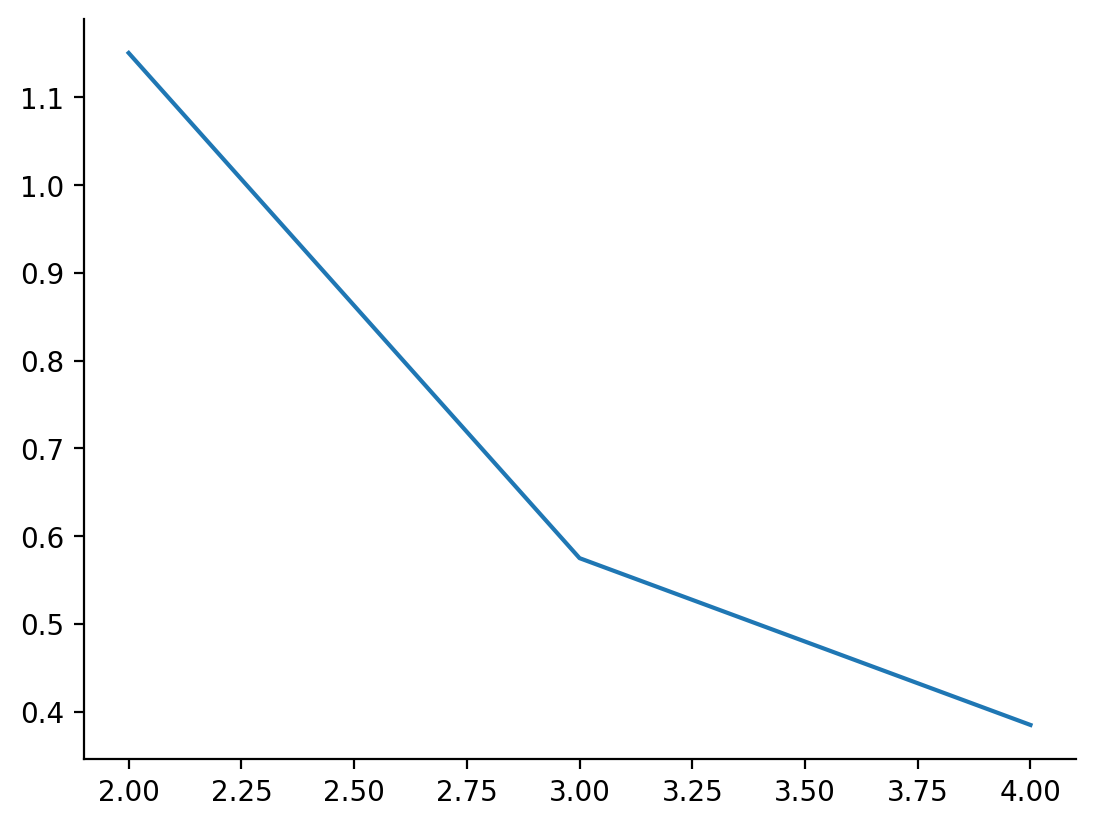

In [559]:
plt.plot(values_delta)

<Axes: >

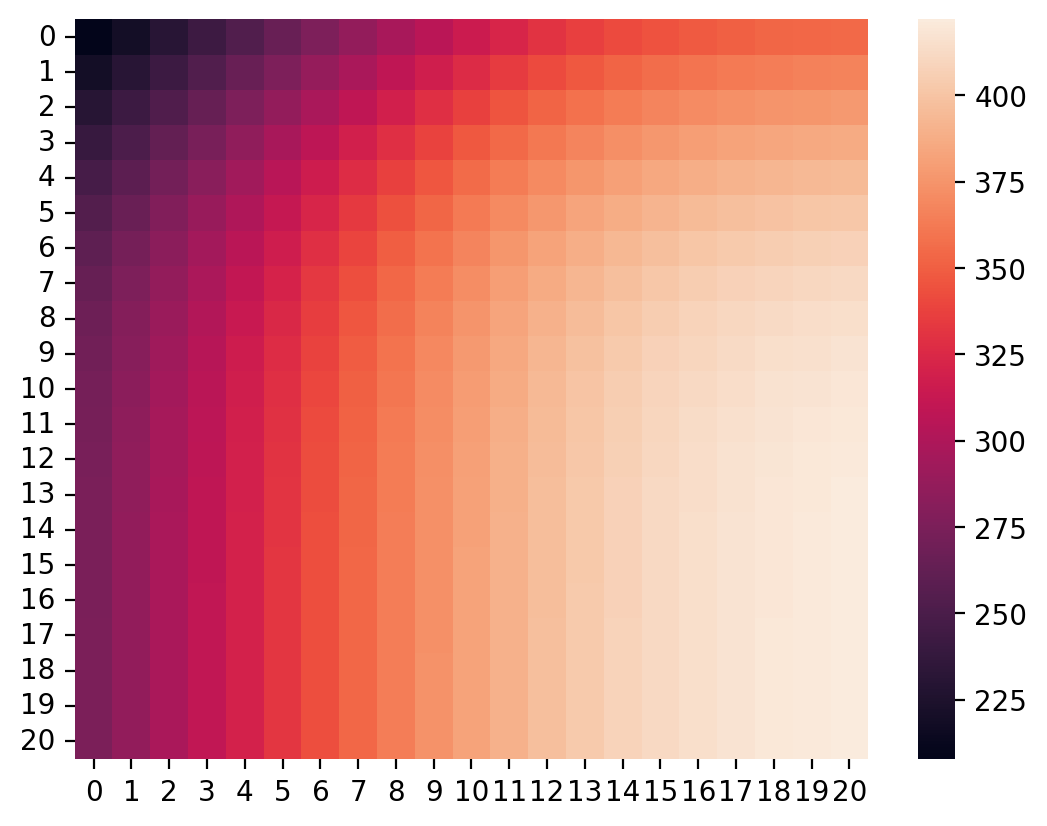

In [560]:
sns.heatmap(V)

In [561]:
%%time
policy = update_policy(states, states, V, actions)

CPU times: user 1min 46s, sys: 1.02 s, total: 1min 47s
Wall time: 2.03 s


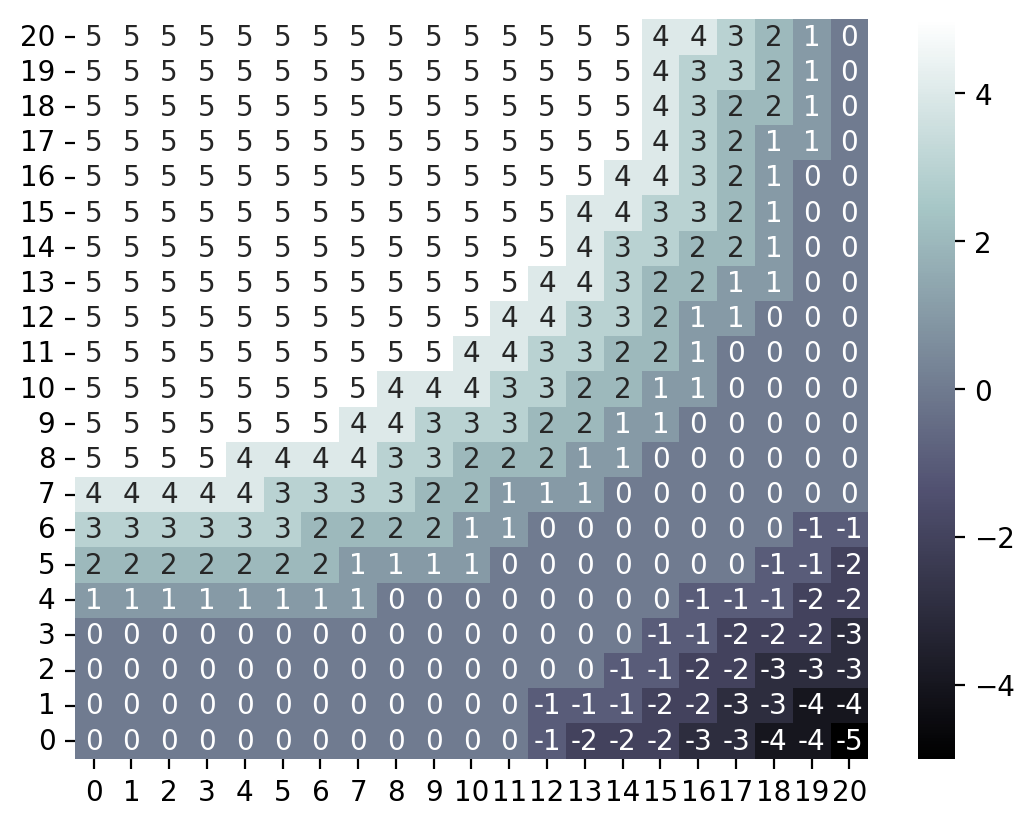

In [562]:
fig, ax = plt.subplots()
sns.heatmap(policy, cmap="bone", ax=ax, annot=True)
ax.invert_yaxis()

In [ ]:
eval_value_function_entry(20, 0, policy, V)

In [ ]:
update_policy_entry(13, 3, V, actions)

In [ ]:
action_value_function_entry(13, 3, action=1, value_function=V)

---

## Old stuff

In [40]:
value_grid = jnp.zeros((max_cars + 1, max_cars + 1))
policy = jnp.zeros((2 * max_car_move + 1, max_cars + 1, max_cars + 1))

# Start with moving no cars
n_move = 0 + 5
policy = policy.at[5].set(1)


In [5]:
max_elements = 20
discount = 0.9

@jax.jit
def value_function(state, action_array, value_grid, discount):
    state_a, state_b = state
    action = action_array.argmax() - 5
    
    action_clipped = jnp.clip(action, -state_b, state_a)
    is_valid_action = action == action_clipped
    
    with loops.Scope() as s:
        # cost of moving cars overnight
        s.expected_reward = -2.0 * jnp.abs(action)
        
        for n_ret_a in s.range(max_elements):
            for n_req_a in s.range(max_elements):
                for n_ret_b in s.range(max_elements):
                    for n_req_b in s.range(max_elements):
                        
                        pr = pr_transition_a(n_ret_a, n_req_a) * pr_transition_b(n_ret_b, n_req_b)
                                                
                        sa_prime = state_a - action
                        sb_prime = state_b + action
                        
                        n_req_a = jnp.minimum(sa_prime, n_req_a)
                        n_req_b = jnp.minimum(sb_prime, n_req_b)
                                                
                        sa_prime = sa_prime + n_ret_a - n_req_a
                        sb_prime = sb_prime + n_ret_b - n_req_b
                        
                        sa_prime = jnp.clip(sa_prime, 0, 20)
                        sb_prime = jnp.clip(sb_prime, 0, 20)

                        reward = 10.0 * (n_req_a + n_req_b)
                            
                        value_config = reward + discount * value_grid[sa_prime, sb_prime]
                        s.expected_reward += pr * value_config
                        
    return s.expected_reward * is_valid_action

In [6]:
vmap_value_function = jax.vmap(value_function, (1, 1, None, None), out_axes=0)
vmap_value_function = jax.vmap(vmap_value_function, (2, 2, None, None), out_axes=1)

In [7]:
improv_value_function = jax.vmap(value_function, (1, None, None, None), out_axes=0)
improv_value_function = jax.vmap(improv_value_function, (2, None, None, None), out_axes=1)
improv_value_function = jax.vmap(improv_value_function, (None, 0, None, None), out_axes=2)

## Iteration

In [8]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)
value_array = jnp.zeros((21, 21))
vrange = jnp.mgrid[:21, :21]
discount = 0.9
arange_ix = jnp.eye(11).astype(int) # Fixed array to pass to the policy-improvement scheme

In [9]:
@jax.jit
def update(value_array, policy, discount, max_err=0.1, eps=1e-6):
    with loops.Scope() as s:
        s.value_array = value_array
        s.err = max_err + 1.0
        s.ix = 0
        for _ in s.while_range(lambda: s.err > max_err):
            update_value_array = vmap_value_function(vrange, policy, s.value_array, discount)
            s.err = jnp.abs(update_value_array / (s.value_array + eps) - 1).max()
            s.value_array = update_value_array
            s.ix += 1
    return s.ix, s.value_array

In [10]:
threshold = 0.95
value_array = jnp.zeros((21, 21))
policy_ix = jnp.zeros((21, 21))
policy_hist = []

In [11]:
ix = 0
is_stable = False
policy_hist_ix = []
threshold = 0.95

while not is_stable:
    print(f"it: {ix+1:02}")
    nsteps, value_array = update(value_array, policy, discount)
    q_improv = improv_value_function(vrange, arange_ix, value_array, discount).block_until_ready()
    curr_threshold = (policy_ix == q_improv.argmax(axis=-1)).mean().item()
    is_stable = curr_threshold >= threshold
    policy_ix = q_improv.argmax(axis=-1)
    policy = jnp.transpose(jax.nn.one_hot(policy_ix, 11), (2, 0, 1))
    print(f"threshold: {curr_threshold:0.2%}", end="\n\n")
    policy_hist_ix.append(policy_ix)
    ix += 1

it: 01
threshold: 0.00%

it: 02
threshold: 38.78%

it: 03
threshold: 87.76%

it: 04
threshold: 97.73%



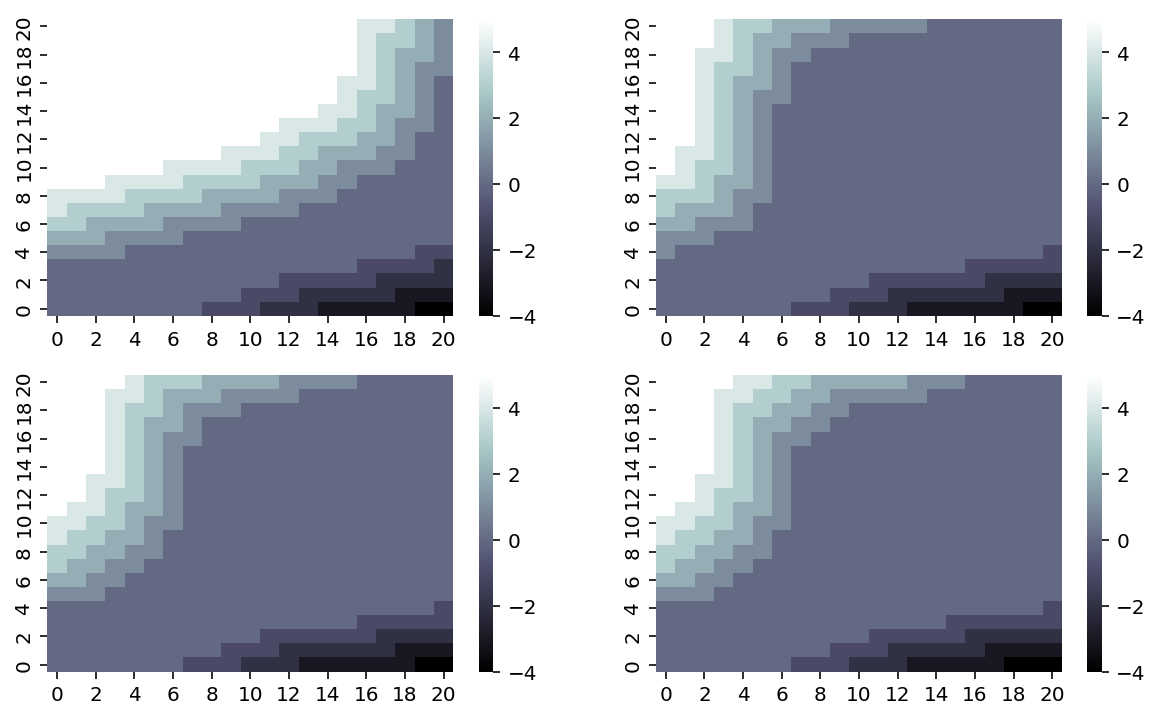

In [12]:
policy_hist = jnp.stack(policy_hist_ix, axis=0) - 5
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for axi, policy_i in zip(ax, policy_hist):
    sns.heatmap(policy_i, ax=axi, cbar=True, cmap="bone")
    axi.invert_yaxis()

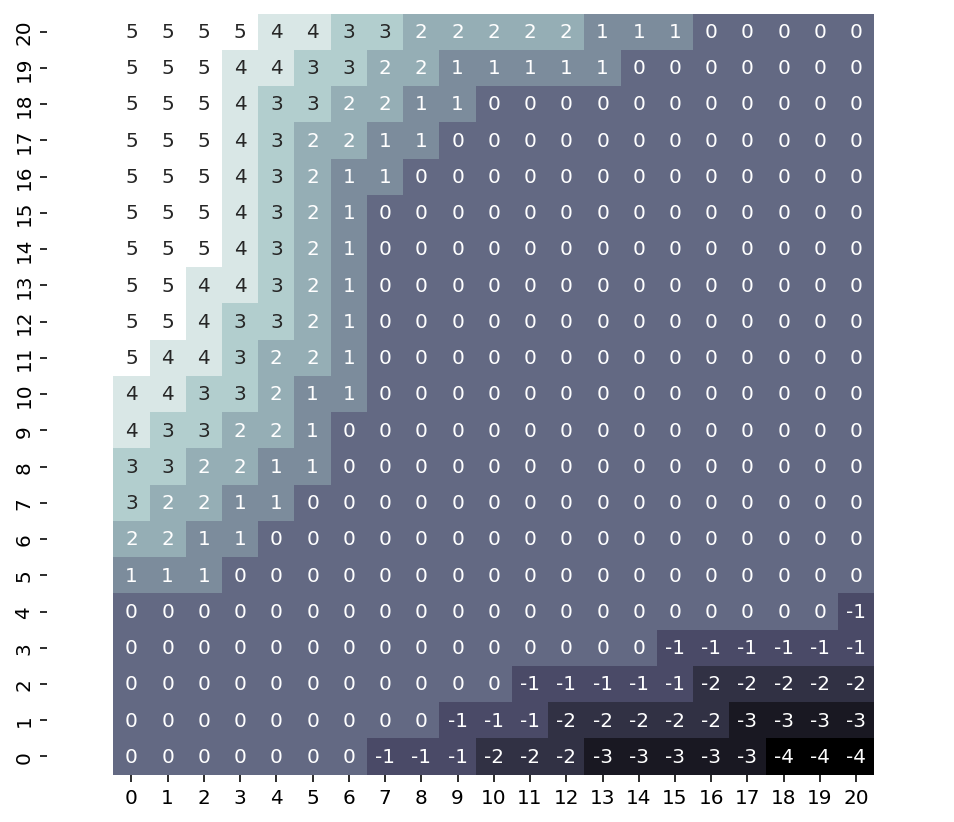

In [13]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(policy_hist[-1], cmap="bone", cbar=False, ax=ax, annot=True)
ax.axis("equal")
ax.invert_yaxis()

# References

* https://towardsdatascience.com/elucidating-policy-iteration-in-reinforcement-learning-jacks-car-rental-problem-d41b34c8aec7
* https://jax.readthedocs.io/en/latest/jax.experimental.loops.html